<a href="https://colab.research.google.com/github/jasonwashburn/ColabNotebooks/blob/main/06_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File Setup

In [3]:
!cp "/content/drive/MyDrive/Colab Notebooks/SpamData.zip" ./
!unzip SpamData

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/._02200.2f5bbdb813d3a4f97b7191e764e1ce61  
  inflating: SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/01482.a3576ddec34b0481a9a671c1f3c141c3  
  inflating: __MACOSX/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/._01482.a3576ddec34b0481a9a671c1f3c141c3  
  inflating: SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/00120.4de6f88fbcb22a39a0498f84d9ce358b  
  inflating: __MACOSX/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/._00120.4de6f88fbcb22a39a0498f84d9ce358b  
  inflating: SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/01093.a14e2f376790556ad2580f10f761f2cb  
  inflating: __MACOSX/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/._01093.a14e2f376790556ad2580f10f761f2cb  
  inflating: SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/00240.6430542510c59bcb5e4cca0112eff3ac  
  inflating: __MACOSX/SpamData/01

# Imports

In [66]:
from os import walk
from os.path import join
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

## Constants

In [36]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"

In [5]:
print(SPAM_1_PATH)

SpamData/01_Processing/spam_assassin_corpus/spam_1


## Reading Files

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [7]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [8]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == "\n":
        is_body = True

stream.close()

#email_body = "\n".join(lines)
#print(email_body)

print(lines)

['\n', 'Dear Mr Still\n', '\n', 'Good tidings to you and all your staff for the festive season ahead (Christmas).\n', 'Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa\'s Grotto" in your store.\n', 'But WAIT! You\'re probably thinking: "What makes him so special?"\n', 'Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.\n', 'You will note also, from the enclosed sketch, that I have radically redesigned Santa\'s outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.\n', 'I look forward to hearing from you.\n', '\n', 'Best wishes\n', 'Robin C

# Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [8]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):

        for file_name in filenames:

            filepath = join(root, file_name)

            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True

            stream.close()

            email_body = "\n".join(lines)
            
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [13]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

spam_emails.head()

,MESSAGE,CATEGORY
00329.af4af411fb1268d1461b29fa2d2145a3,"<HTML>\n\n<BODY>\n\n<iframe align=""center"" mar...",1
00436.4ef1bd17d9202e4229485da7a47afd6c,This is a multi-part message in MIME format.\n...,1
00259.7b838a90b63541213eff9099e1a1aa3c,<HTML><HEAD>\n\n<META http-equiv=Content-Type ...,1
00434.8507c67a652e01636df9b92a0a397193,You can save thousands of dollars over the cou...,1
00281.db28f3aab77ff478279d8de20d572b42,\n\n<html><body><center>\n\n\n\n<table bgcolor...,1


In [14]:
spam_emails.shape

(1898, 2)

In [15]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

ham_emails.head()

,MESSAGE,CATEGORY
00783.14a724489223eda0063e308c6914ee38,--]\n\n--] Anyone heard of this law before?\n\...,0
01505.736da2d34e20948b7287da130be6e7da,I just picked up Razor SDK 2.03 and 2.14 agen...,0
00315.57e3c784e646e449c12675f2981a956f,"On Mon, 2002-08-26 at 11:41, Mike Masnick wrot...",0
00192.9ab41d05f7b9bad7f7eccf7d393293dc,">>>>> ""A"" == Adam L Beberg <beberg@mithral.com...",0
00486.8294dd2af26dd3d759390f412bbec227,Robert Harley:\n\n>It is perfectly obvious tha...,0


In [16]:
ham_emails.shape

(3901, 2)

In [17]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is ", data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00329.af4af411fb1268d1461b29fa2d2145a3,"<HTML>\n\n<BODY>\n\n<iframe align=""center"" mar...",1
00436.4ef1bd17d9202e4229485da7a47afd6c,This is a multi-part message in MIME format.\n...,1
00259.7b838a90b63541213eff9099e1a1aa3c,<HTML><HEAD>\n\n<META http-equiv=Content-Type ...,1
00434.8507c67a652e01636df9b92a0a397193,You can save thousands of dollars over the cou...,1
00281.db28f3aab77ff478279d8de20d572b42,\n\n<html><body><center>\n\n\n\n<table bgcolor...,1


# Data Cleaning: Checking for Missing Values

In [20]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [21]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [22]:
(data.MESSAGE.str.len() == 0).sum()

3

### Locate empty emails

In [23]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [24]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove System File Entries from Dataframe

In [25]:
data.drop(['cmds'], inplace=True)

In [28]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [30]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [34]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<HTML>\n\n<BODY>\n\n<iframe align=""center"" mar...",1,00329.af4af411fb1268d1461b29fa2d2145a3
1,This is a multi-part message in MIME format.\n...,1,00436.4ef1bd17d9202e4229485da7a47afd6c
2,<HTML><HEAD>\n\n<META http-equiv=Content-Type ...,1,00259.7b838a90b63541213eff9099e1a1aa3c
3,You can save thousands of dollars over the cou...,1,00434.8507c67a652e01636df9b92a0a397193
4,\n\n<html><body><center>\n\n\n\n<table bgcolor...,1,00281.db28f3aab77ff478279d8de20d572b42


In [35]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"ok, so i was also learning about css this week...",0,00135.0d5ad403b361fd41210885d4e4b44e81
5792,----------------------------------------------...,0,00672.96646a3185ee6d8828c0ca3d1e91ce0a
5793,>===== Original Message From deedsmis@aculink....,0,00237.f1cc68d90b0a47f01678c5eb0dc1ea7a
5794,"On Thu, 18 Jul 2002 13:00:29 +0200\n\nMatthias...",0,00674.bce8a0d5cf2fcc9888c9c2f88725df78
5795,My understanding was 'not really'. They suffe...,0,01061.c4f15278aa6a4a993287302c744e6c22


# Save to File using Pandas

In [37]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [38]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [40]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

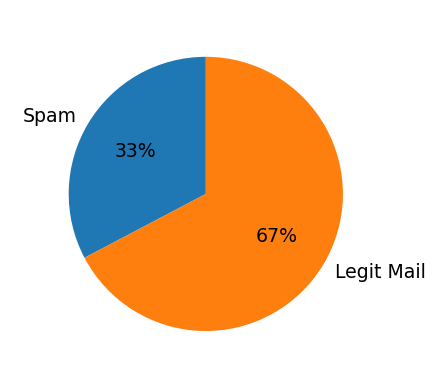

In [55]:
category_names = ['Spam', "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%')
plt.show()

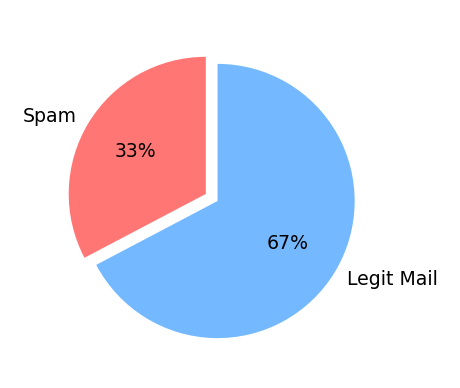

In [57]:
custom_colors=['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

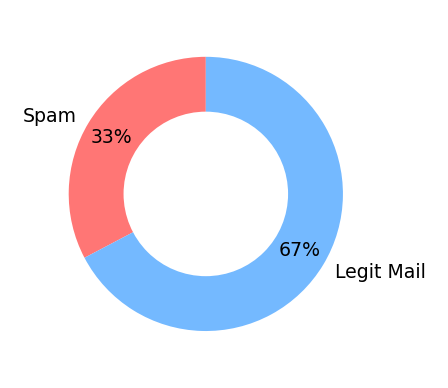

In [62]:
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

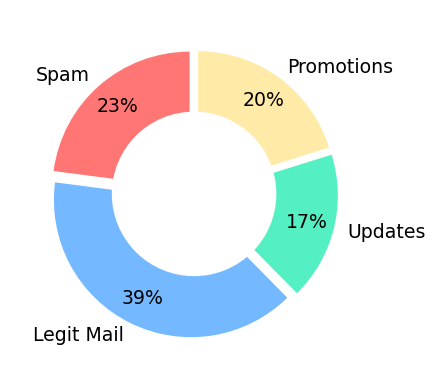

In [64]:
category_names = ['Spam', "Legit Mail", 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors=['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

# Natural Language Processing

### Text Pre-Processing

In [65]:
# convert to lower case
msg = "All work and no play makes Jack a dull boy."
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [67]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [70]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Tokenizing

In [69]:
msg = "All work and no play makes Jack a dull boy."
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [74]:
stop_words = set(stopwords.words('english'))
type(stop_words)

set

In [73]:
if 'this' in stop_words: print('Found it!')

Found it!


In [75]:
if 'hello' not in stop_words: print('Nope, not in here!')

Nope, not in here!


In [78]:
msg = "All work and no play makes Jack a dull boy. To be or not to be."
words = word_tokenize(msg.lower())

filtered_words = [word for word in words if word not in stop_words]
filtered_words


['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']